# 🚀 Introduction to WaveSongs

<br>

This tutorial guides users through analyzing, visualizing, and generating synthetic birdsongs using the `wavesongs` Python package. 

If you are using Google Colab uncomment and execute the following cell:

In [1]:
# ! git clone https://github.com/wavesongs/wavesongs
# ! pip install wavesongs

# # enable hird party widgets (ipympl)
# from google.colab import output
# output.enable_custom_widget_manager()

# # correct ProjDirs parameters,
# audios = "/content/wavesongs/assets/audio"
# results = "/content/wavesongs/assets/audio/results"

:::{caution}
:name: warning
If you encounter an error message, reset the kernel and run the above cell again. After that, everything should work successfully.
:::


Then, follow the [installation guide](https://github.com/wavesongs/wavesongs#%EF%B8%8F-installation) to set up the evironment and install the required libraries.

## Libraries

Import the required classes and functions from `wavesongs`:

In [1]:
# Select matplotlib backend and enable interactive plots
# %matplotlib ipympl

from wavesongs.utils.paths import ProjDirs   # Manages project files
from wavesongs.objs.syllable import Syllable # Song objects
from wavesongs.objs.song import Song         # Song objects
from wavesongs import plot                   # Plotting utilities
from wavesongs.utils.tools import get_roi    # Data extraction tools

## Song Object

To use objects like `Syllable` or `Song`, first define a project directory using a `ProjDirs` object. This object manages generated files such as images, audio files, and CSVs.

:::{code-block} text
📁 project_root
└── 📁 assets
    ├── 📁 results
    │   ├── 📁 mg_params
    │   ├── 📁 audios
    │   └── 📁 figures
    └── 📁 audios
        ├── <audio sample files>
        └── <meta data>.csv
:::

Next, create a `Song` instance with the project directory and a file name. In this tutorial, we use the audio file `574179401 - Zonotrichia Capensis.wav` located at `assets/audio/`.

Once the song is defined, compute its acoustic features. You can specify parameters such as the Fast Fourier Transform (FFT) window and fundamental frequency (FF) method.

To display the spectrogram, use the `plots` module and the `spectrogram_waveform` function.

The name assigned to the song and syllables, "Copetón," is the common name for Zonotrichia capensis in Colombia.

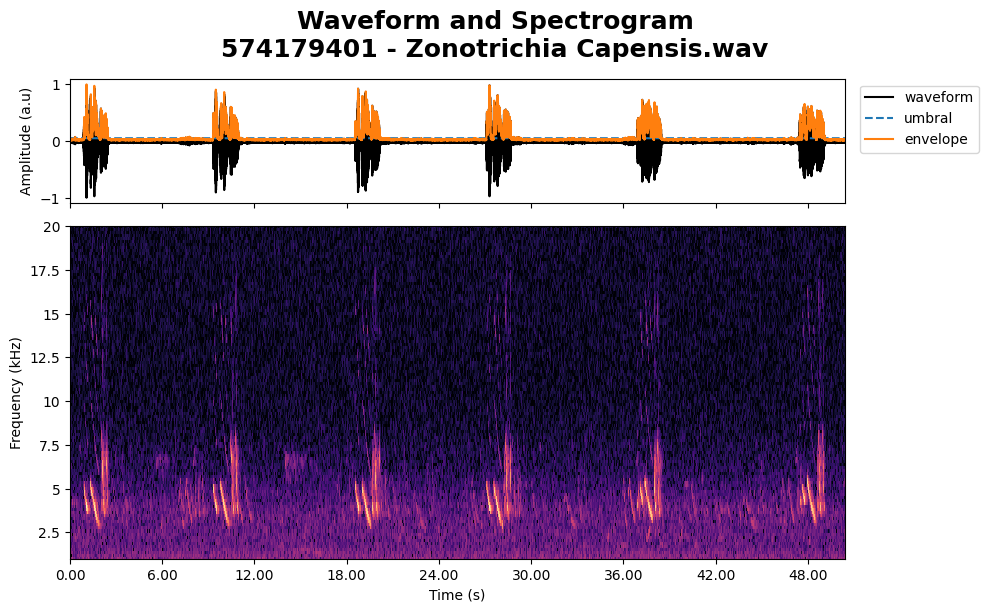

In [2]:
proj_dirs = ProjDirs(audios="../../assets/audio", results="../../assets/results")

# Define the song and compute its acoustic features
copeton_song = Song(proj_dirs, file_id="574179401")
copeton_song.acoustical_features(umbral_FF=1.4, NN=256)

# Display the song
plot.spectrogram_waveform(copeton_song, save=False)

In [3]:
copeton_song.play()

Long audio files can slow down plot response. A best practice is to define a **region of interest (RoI)**, such as a complete birdsong.

## Birdsong

To select a specific time interval, set `select_time=True` and define the start and end of the RoI.

Image save at ../../assets/results/images/574179401-ZonotrichiaCapensis-Song.png


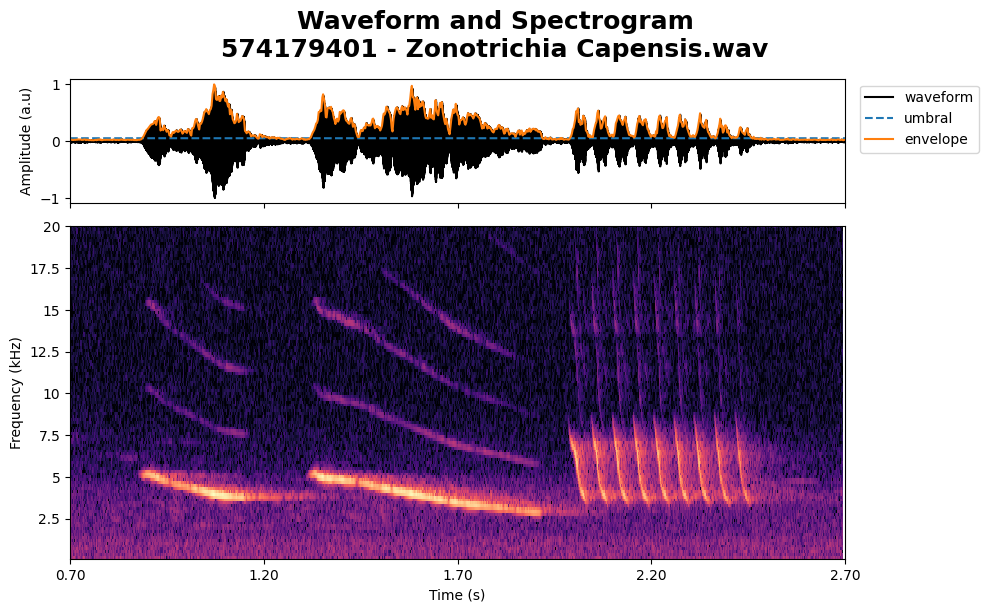

In [4]:
# Define time interval for the RoI
tlim_roi = (0.7, 2.7)

copeton_syllable = Song(proj_dirs, file_id="574179401", tlim=tlim_roi)
copeton_syllable.acoustical_features(umbral_FF=1.4, NN=256, ff_method="yin", flim=(1e2, 2e4))

klicker_times = plot.spectrogram_waveform(copeton_syllable, tlim=tlim_roi,
                                           select_time=True, save=True)

In [5]:
copeton_syllable.play()

This function returns an array of measurements, where each element is a vector containing time and frequency range values.

:::{warning}
If no selection is made, an error will occur.
:::

:::{note}The fundamental frequency is computed with the yin/pyin algorithm. Although the algorithm give pretty good results, the beginning may not be well computed.
:::

In [16]:
data = get_roi(klicker_times)
tlim, flim = data[0] # index = 0: first pair
t0 = tlim[0] + copeton_syllable.t0_bs
tend = tlim[1] + copeton_syllable.t0_bs
print(f"Region of Interest: (tini = {t0:.4f} s, tend = {tend:.4f} s)")

Region of Interest: (tini = 0.8807 s, tend = 1.3034 s)


## Syllable

Image save at ../../assets/results/images/574179401-ZonotrichiaCapensis-0-intro-down


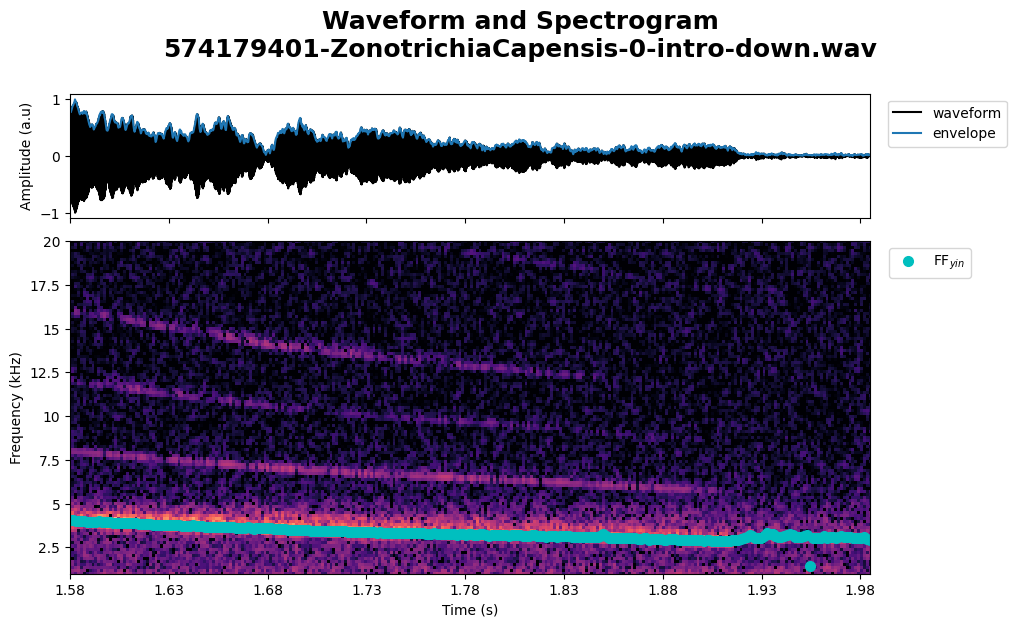

In [7]:
# Define a syllable object within the selected RoI
tlim = (0.880, 1.2914)
copeton_syllable_0 = Syllable(obj=copeton_syllable, tlim=tlim, type="intro-down", no_syllable="0")
copeton_syllable_0.acoustical_features(NN=256)

# Display the syllable's spectrogram
plot.spectrogram_waveform(copeton_syllable_0, ff_on=True, save=True)

In [8]:
copeton_syllable_0.play()

In [9]:
# Write audio
copeton_syllable_0.write_audio()

Audio saved at ../../assets/results/audios/574179401-ZonotrichiaCapensis-syllable-0.wav.


## Synthetic Syllable

We can generate a synthetic syllable using the optimizer module, which solves a minimization problem to find the optimal parameters that make the generated song most similar to the real one.

### Optimal Parameters

The birdsong model consists of four constant parameters that define the labial tension and air-sac pressure ($a_0, b_0, b_1, b_2$). Both variables change over time, but we are just interested in the coefficients.

In [20]:
from wavesongs import optimizer

optimal_z = optimizer.optimal_params(syllable=copeton_syllable_0, Ns=10, full_output=True)
print(f"\nOptimal model values (alpha and beta coefficients):\n\t{optimal_z}")


Computing a0*...
Optimization terminated successfully.
         Current function value: 0.005652
         Iterations: 1
         Function evaluations: 2
	 Optimal values: a_0=0.0010, t=0.52 min

Computing b0*, b1*, and b2*...
Optimization terminated successfully.
         Current function value: 0.001954
         Iterations: 39
         Function evaluations: 75
	 Optimal values: b_0=-0.2144, b_2=1.2973, t=12.37 min
Optimization terminated successfully.
         Current function value: 0.001954
         Iterations: 13
         Function evaluations: 28
	 Optimal values: b_1=1.0000, t=4.00 min

Time of execution: 16.89 min

Optimal model values (alpha and beta coefficients):
	{'a0': 0.00105, 'b0': -0.21438, 'b1': 1.0, 'b2': 1.29729}


### Solution

Now, we generate and visualize the synthetic syllable using the computed optimal parameters, `optimal_z`.

Image save at ../../assets/results/images/synth-574179401-ZonotrichiaCapensis-0-intro-down


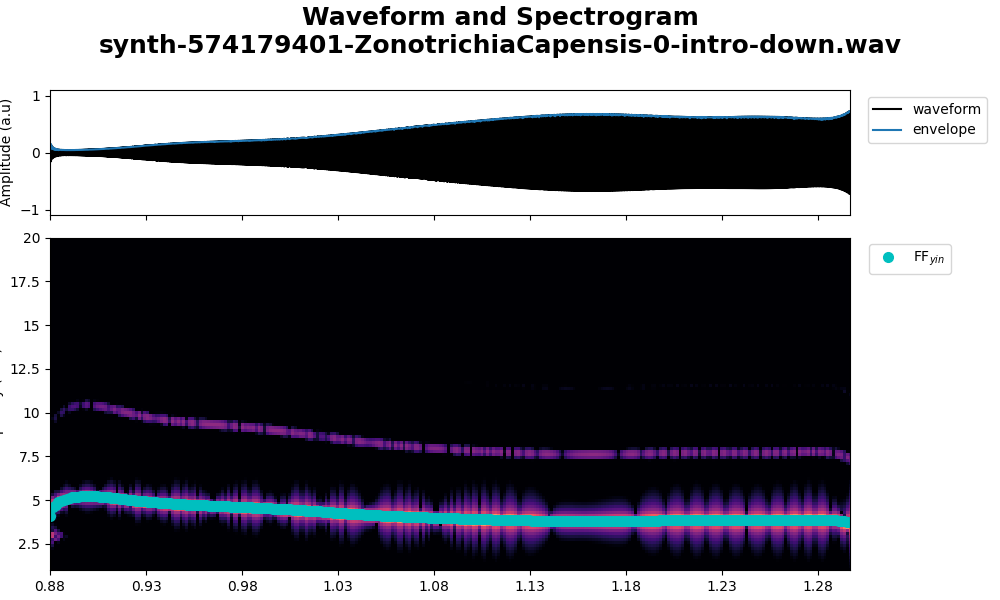

In [21]:
synth_copeton_syllable_0 = copeton_syllable_0.solve(z=optimal_z, method="best")
plot.spectrogram_waveform(synth_copeton_syllable_0, ff_on=True, save=True)

In [10]:
synth_copeton_syllable_0.play()

In [11]:
# Write synthetic sample
synth_copeton_syllable_0.write_audio()

Audio saved at ../../assets/results/audios/synth-574179401-ZonotrichiaCapensis-synth-syllable-0.wav.


In the `solve()` method, there are two approaches available for generating synthetic songs:

1. **`best` Method**: The labial tension is calculated using the formula:  
   $$
   \beta(t) = b_0 + b_1 \cdot \tilde{FF} + b_2 \cdot \tilde{FF}^2
   $$  
   where $\tilde{FF}$ represents the fundamental frequency normalized by $10^4$ Hz.

2. **`fast` Method**: The labial tension is computed as:  
   $$
   \beta(t) = b_0 + b_1 \cdot t + b_2 \cdot t^2
   $$  
   where $t$ denotes time.

Additionally, you can export and import the entire `Syllable` object for further use or analysis. 

#### Saving Curves

##### Export

In [22]:
# Exporting syllable parameters
synth_copeton_syllable_0.export_mg(export_curves=True)

Curves arrays saved at ../../assets/results/mg_params/synth-574179401-ZonotrichiaCapensis-0-curves.csv
Motor gesture parameters saved at ../../assets/results/mg_params/574179401-ZonotrichiaCapensis-0-mg.csv.


##### Import

Image save at ../../assets/results/images/synth-574179401-ZonotrichiaCapensis-0-intro-down


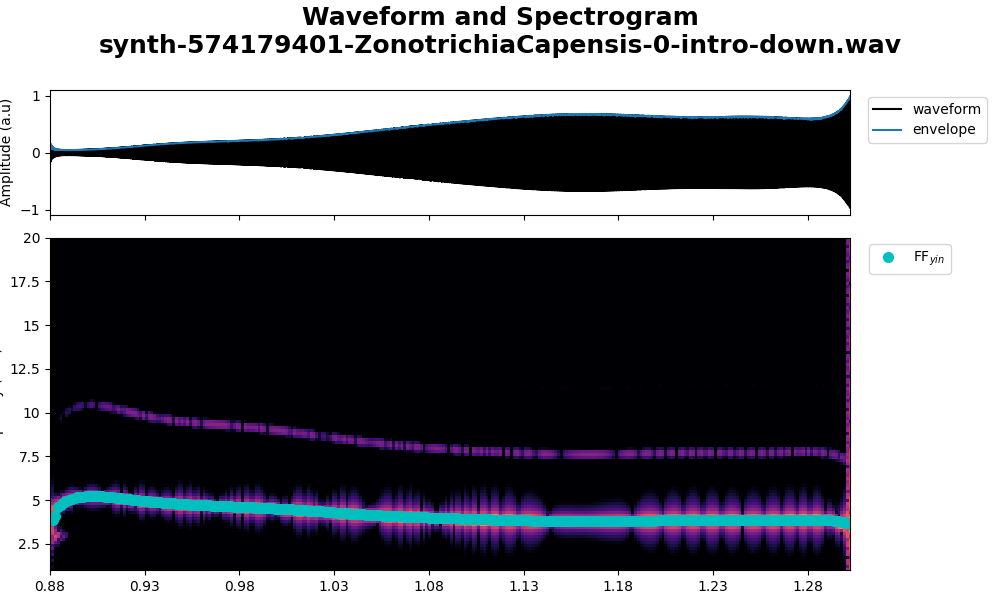

In [3]:
# Importing parameters from csv file
proj_dirs = ProjDirs(audios="../../assets/audio", results="../../assets/results")
imported_synth_copeton_syllable_0 = proj_dirs.import_mg("574179401", no_syllable=0)
plot.spectrogram_waveform(imported_synth_copeton_syllable_0, ff_on=True)

This process generates a CSV file containing all the parameters of the `Syllable`. The file name ends with `"mg"`. If the `best` method is selected, an additional file will be created during export, ending with `"curve"`. This file includes the curve arrays for time ($t$), air-sac pressure ($\alpha(t)$), and labial tension ($\beta(t)$). By default, both files are stored in the directory `assets/results/mg_params/`.

In [4]:
imported_synth_copeton_syllable_0.play()

### Real vs Synthetic Syllables

In [5]:
plot.syllables(copeton_syllable_0, synth_copeton_syllable_0, ff_on=True)

NameError: name 'copeton_syllable_0' is not defined

### Motor Gesture

Image save at synth-574179401-ZonotrichiaCapensis-0-intro-down-mg_params.png


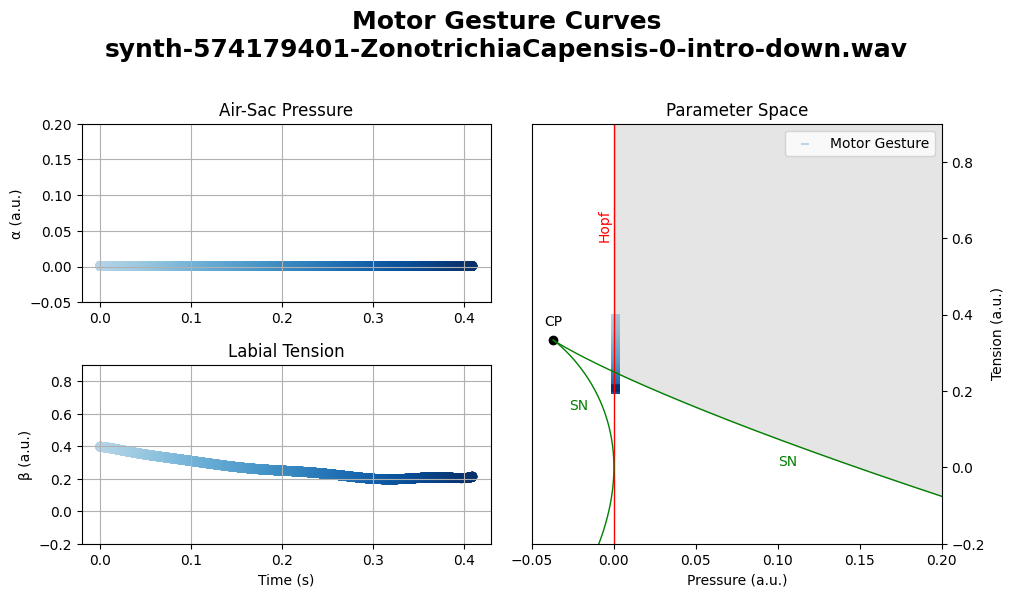

In [16]:
plot.alpha_beta(synth_copeton_syllable_0)

### Model Physical Variables

Image save at synth-574179401-ZonotrichiaCapensis-0-intro-down-PhysicalVariables.png


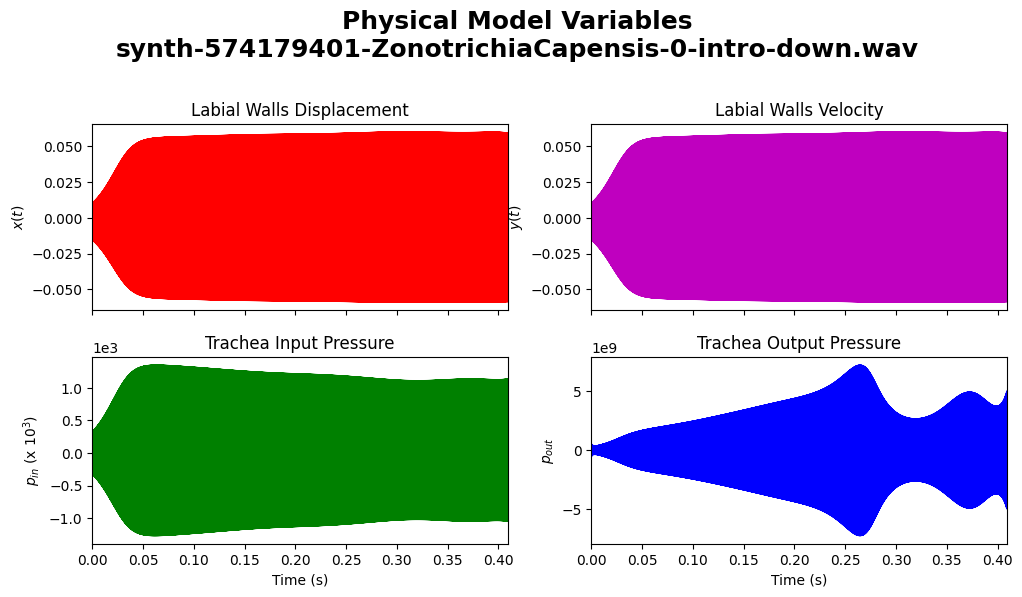

In [17]:
plot.phsyical_variables(synth_copeton_syllable_0)

### Model Score Variables

Image save at 574179401-ZonotrichiaCapensis-0-intro-down-ScoringVariables.png


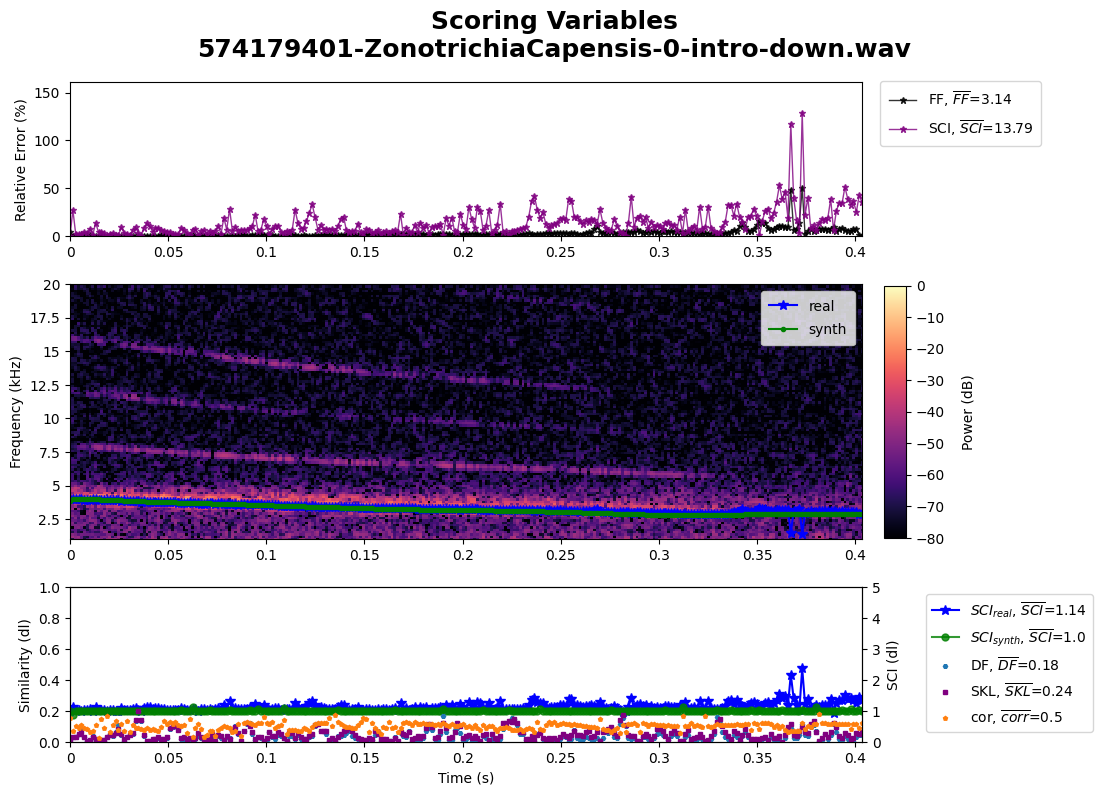

In [18]:
plot.scores(copeton_syllable_0, synth_copeton_syllable_0, save=True)

---

This tutorial introduced **WaveSongs** for bioacoustic analysis, covering setup, song processing, spectrogram visualization, and synthetic syllable generation. By following these steps, you can analyze bird vocalizations and optimize synthetic models for research or educational purposes.

Happy coding! 🎵🔬